In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize R^2 score dictionary
r2_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

mae_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

valid_target_properties = []

In [6]:
# target_property_list = ['voltage', 'energy', 'conductivity', 'columbic_efficiency']
# target_property_list = ['voltage', 'energy', 'conductivity', 'capacity', 'columbic_efficiency']
target_property_list = ['voltage']

In [8]:
gnn_data = pd.read_csv(f'GNN_embedding/data0.csv')

## Train Models

In [ ]:
## Evaluate with a set aside test set 

# Main loop
for target_property in target_property_list:
    try:
        df1 = pd.read_excel(f'data/{target_property}.xlsx')
    except Exception as e:
        print(f"Failed to load data for {target_property}: {e}")
        continue

    avg_df = df1.groupby('jid')['Value'].mean().reset_index()
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    merged_df = pd.merge(avg_df, gnn_data, left_on='jid', right_on='id')
    merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

    # Ensure enough data
    if merged_df.shape[0] < 10:
        print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
        continue

    # Extract features and target
    X = merged_df.drop(columns=['Value', 'id', 'jid'])
    X = X.select_dtypes(include=[np.number])  # only numeric features
    y = merged_df['Value'].values

    if X.shape[0] != len(y):
        print(f"Skipping {target_property} due to X/y shape mismatch.")
        continue

    # Normalize features for MLP/KNN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

    # Store valid target property for plotting
    valid_target_properties.append(target_property)

    # Train and evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores[name].append(r2)

        mae = mean_absolute_error(y_test, y_pred)
        mae_scores[name].append(mae)

        print(f"{name} R² for {target_property}: {r2:.4f}")


In [ ]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

for target_property in target_property_list:
    print(f"STARTING PROPERTY {target_property.upper()}")
    try:
        df1 = pd.read_excel(f'data/{target_property}.xlsx')
    except Exception as e:
        print(f"Failed to load data for {target_property}: {e}")
        continue

    avg_df = df1.groupby('jid')['Value'].mean().reset_index()
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    merged_df = pd.merge(avg_df, gnn_data, left_on='jid', right_on='id')
    merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

    # Ensure enough data
    if merged_df.shape[0] < 10:
        print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
        continue

    # Extract features and target
    X = merged_df.drop(columns=['Value', 'id', 'jid'])
    X = X.select_dtypes(include=[np.number])  # only numeric features
    y = merged_df['Value'].values

    if X.shape[0] != len(y):
        print(f"Skipping {target_property} due to X/y shape mismatch.")
        continue

    # Normalize features for MLP/KNN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Store valid target property for plotting
    valid_target_properties.append(target_property)

    # Train and evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        print(f"Starting model {name}")
        fold_r2_accuracies = [] 
        fold_mae_accuracies = [] 

        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            fold_r2_accuracies.append(r2)

            mae = mean_absolute_error(y_test, y_pred)
            fold_mae_accuracies.append(mae)

            # print(f"Completed fold {fold} with MAE {mae}")

        mae_scores[name].append(np.average(fold_mae_accuracies))
        r2_scores[name].append(np.average(fold_r2_accuracies))

        print(f"Finished property {name} with average MAE {np.average(fold_mae_accuracies)}")

        # print(f"{name} R² for {target_property}: {r2:.4f}")

STARTING PROPERTY VOLTAGE
Starting model Linear Regression
Finished property Linear Regression with average MAE 1.5955309325394293
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 0.678297093808721
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 0.5996656964876336
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 0.6238891551607797
Starting model Decision Tree Regressor
Finished property Decision Tree Regressor with average MAE 0.8662967456691517
STARTING PROPERTY ENERGY
Starting model Linear Regression
Finished property Linear Regression with average MAE 883.2180330738399
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 517.9515196454038
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 458.80581779538
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 438.8696224806172
Startin

In [50]:
mae_scores

{'Linear Regression': [1.5955309325394293,
  883.2180330738399,
  5.550326273977478,
  440.9942775673553,
  17.30059831730769],
 'MLP Regressor': [0.678297093808721,
  517.9515196454038,
  3.6546112553715924,
  245.02487864399527,
  17.964308447234043],
 'Random Forest Regressor': [0.5996656964876336,
  458.80581779538,
  3.257638355129324,
  242.89344204982882,
  12.235165742865325],
 'KNN Regressor': [0.6238891551607797,
  438.8696224806172,
  2.5643599210671866,
  239.03476384510623,
  12.452929054939636],
 'Decision Tree Regressor': [0.8662967456691517,
  665.0937519382569,
  4.226100763903528,
  357.95986155676474,
  17.513581384492973]}

## Plot Final Scores

Use mae_scores or r2_scores to pick a metric

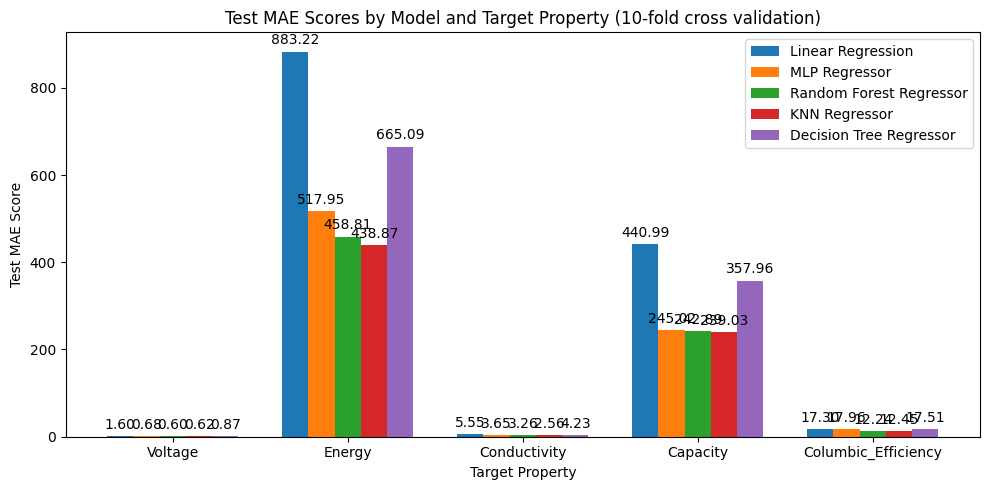

In [ ]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores(scores)
    rects_visible = ax.bar(x + offset, visible, width, label=label, color=color)

    # Draw hatched rectangles for invalid scores at fixed height
    hatch_height = 0.05  # fixed height for placeholder
    for i, invalid in enumerate(is_invalid):
        if invalid:
            ax.bar(x[i] + offset, hatch_height, width,
                   fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Test MAE Scores by Model and Target Property (10-fold cross validation)')
ax.set_xticks(x)
ax.set_xticklabels([prop.title() for prop in target_property_list], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()


[0 1 2 3 4] -0.3 [1.5955309325394293] 0.15 Linear Regression tab:blue
<BarContainer object of 1 artists>
[0 1 2 3 4] -0.15 [0.678297093808721] 0.15 MLP Regressor tab:orange
<BarContainer object of 1 artists>
[0 1 2 3 4] 0 [0.5996656964876336] 0.15 Random Forest Regressor tab:green
<BarContainer object of 1 artists>
[0 1 2 3 4] 0.15 [0.6238891551607797] 0.15 KNN Regressor tab:red
<BarContainer object of 1 artists>
[0 1 2 3 4] 0.3 [0.8662967456691517] 0.15 Decision Tree Regressor tab:purple
<BarContainer object of 1 artists>


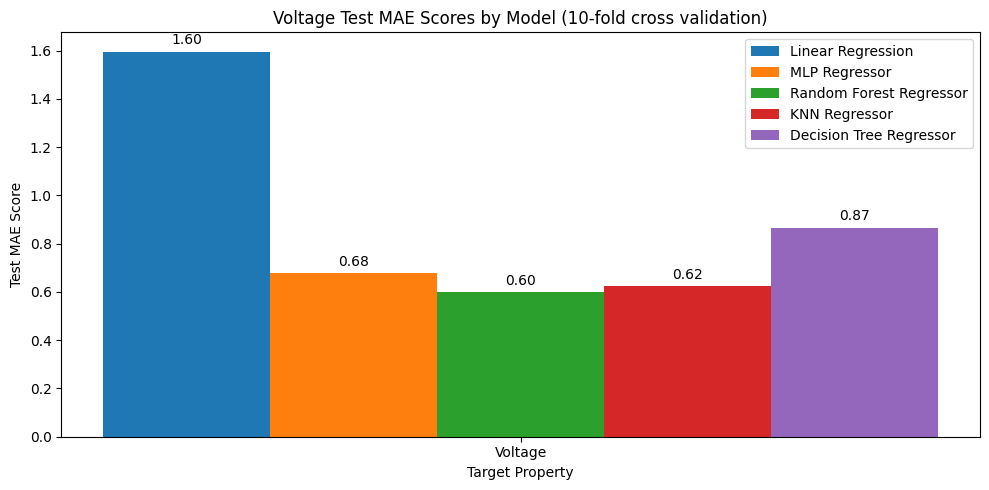

In [53]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores([scores[0]])
    rects_visible = ax.bar(x[0] + offset, visible, width, label=label, color=color)
    print(x, offset, visible, width, label, color)
    print(rects_visible)

    # Draw hatched rectangles for invalid scores at fixed height
    # hatch_height = 0.05  # fixed height for placeholder
    # for i, invalid in enumerate(is_invalid):
    #     if invalid:
    #         ax.bar(x[i] + offset, hatch_height, width,
    #                fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Voltage Test MAE Scores by Model (10-fold cross validation)')
ax.set_xticks([0])

ax.set_xticklabels(['Voltage'], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()


## Hyperparameter search

In [ ]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

target_property = "voltage"
df1 = pd.read_excel(f'data/{target_property}.xlsx')

avg_df = df1.groupby('jid')['Value'].mean().reset_index()
avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

merged_df = pd.merge(avg_df, gnn_data, left_on='jid', right_on='id')
merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()


# Extract features and target
X = merged_df.drop(columns=['Value', 'id', 'jid'])
X = X.select_dtypes(include=[np.number])  # only numeric features
y = merged_df['Value'].values

# Normalize features for MLP/KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)

param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
}


In [ ]:
## running the hyperparameter search 
## took 62:32 minutes

from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
param_list = list(ParameterSampler(param_dist, n_iter=50, random_state=42))
results = []

for params in tqdm(param_list):
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    scores = []
    for train_idx, val_idx in kf.split(X):  # manually perform CV
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[val_idx])
        mse = mean_absolute_error(y[val_idx], y_pred)
        scores.append(mse)
    results.append((params, np.mean(scores)))

100%|██████████| 50/50 [1:02:32<00:00, 75.05s/it] 


In [70]:
results_df = pd.DataFrame(results, columns=['params', 'mean_score'])

params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

In [71]:
results_df.to_csv("random_forest_results.csv", index=False)

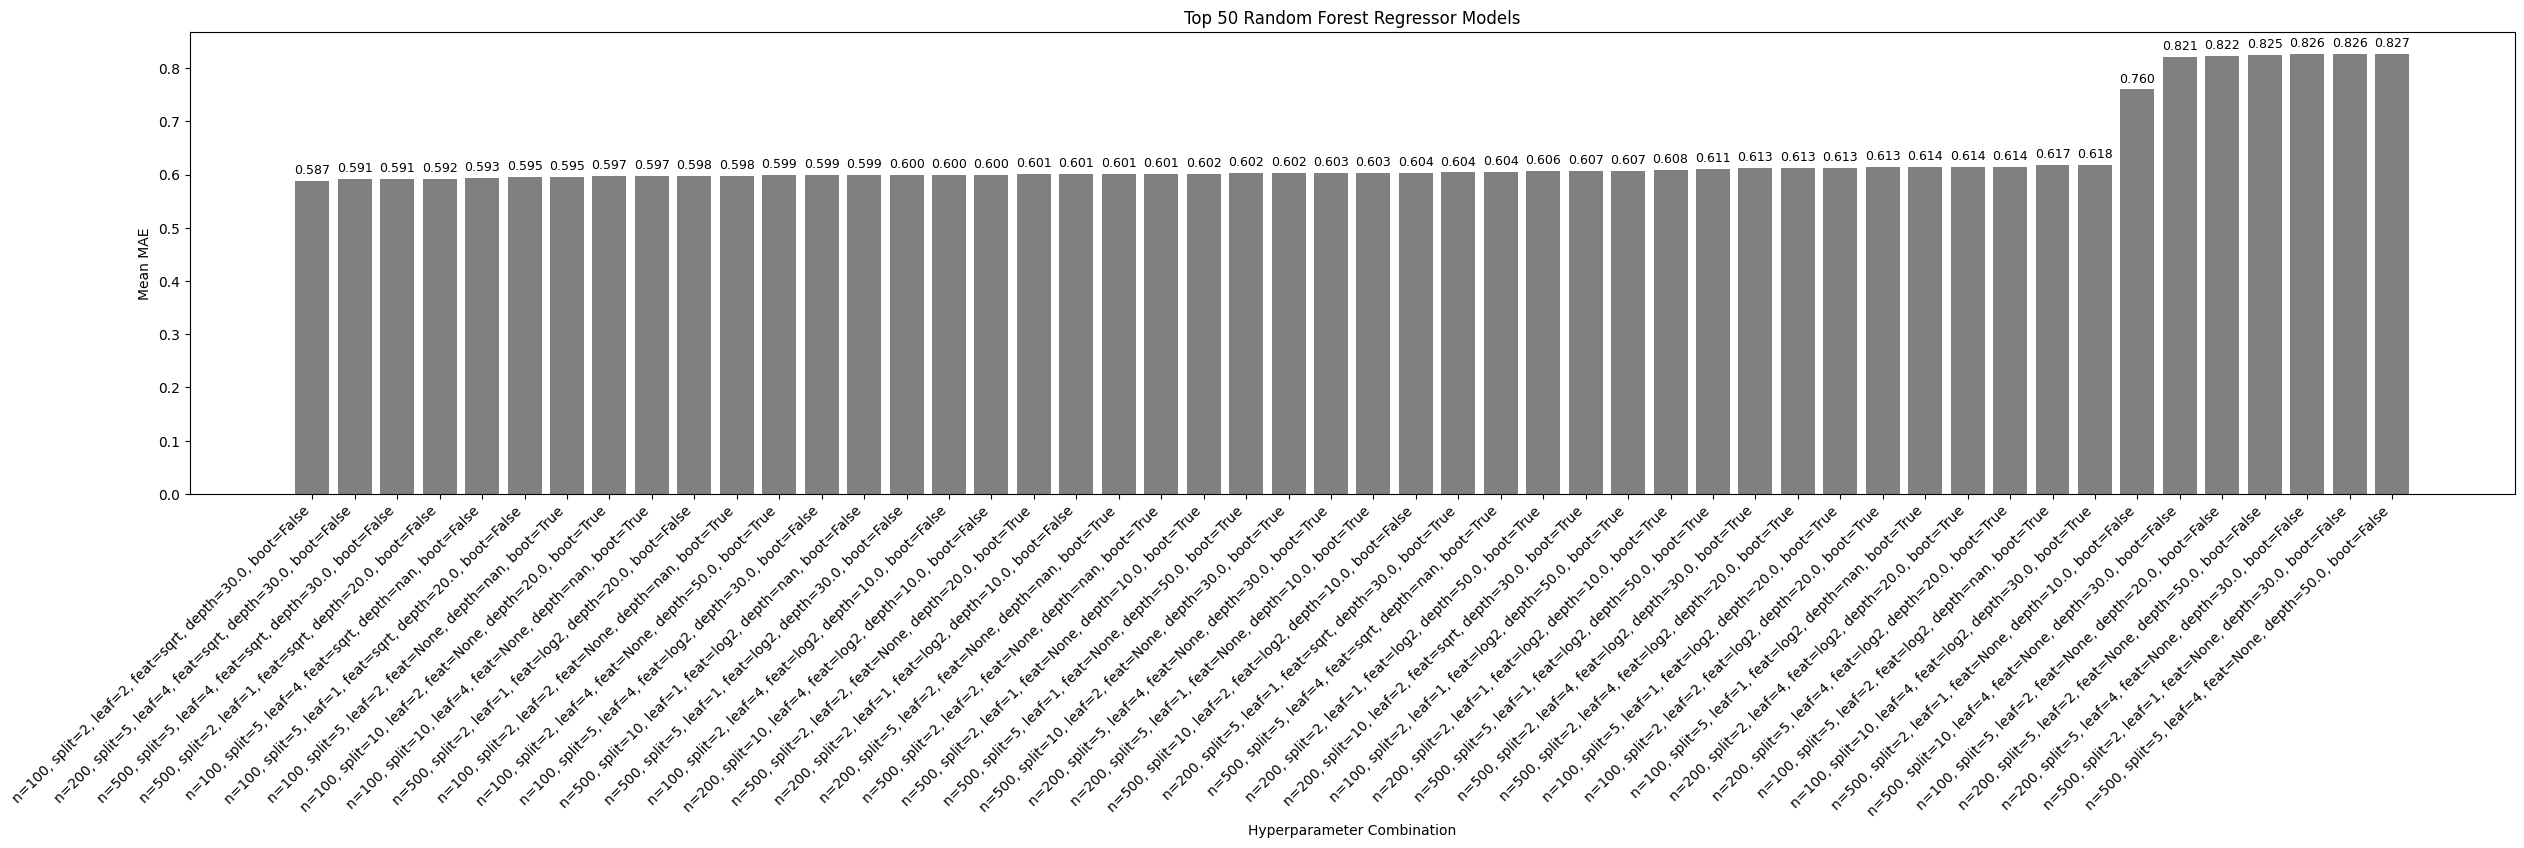

In [ ]:
import matplotlib.pyplot as plt

# Sort and select top N models
top_n = 10
plot_df = results_df.sort_values("mean_score").head(top_n).copy()

# Create readable labels
plot_df["params_str"] = plot_df.apply(
    lambda row: f"n={row.n_estimators}, split={row.min_samples_split}, leaf={row.min_samples_leaf}, feat={row.max_features}, depth={row.max_depth}, boot={row.bootstrap}",
    axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(30, 6))
bars = ax.bar(plot_df["params_str"], plot_df["mean_score"], color="gray")

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * max(plot_df["mean_score"]),
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# Labels and layout
ax.set_ylabel("Mean MAE")
ax.set_xlabel("Hyperparameter Combination")
ax.set_title(f"Top {top_n} Random Forest Regressor Models")
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()


In [76]:
results_df

,mean_score,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
30,0.587316,100,2,2,sqrt,30.0,False
1,0.591118,200,5,4,sqrt,30.0,False
32,0.591330,500,5,4,sqrt,30.0,False
9,0.592173,500,2,1,sqrt,20.0,False
15,0.592812,100,5,4,sqrt,NaN,False
49,0.594847,100,5,1,sqrt,20.0,False
10,0.595456,100,5,2,None,NaN,True
11,0.597442,100,10,2,None,20.0,True
29,0.597498,100,10,4,None,NaN,True
7,0.597511,500,2,1,log2,20.0,False


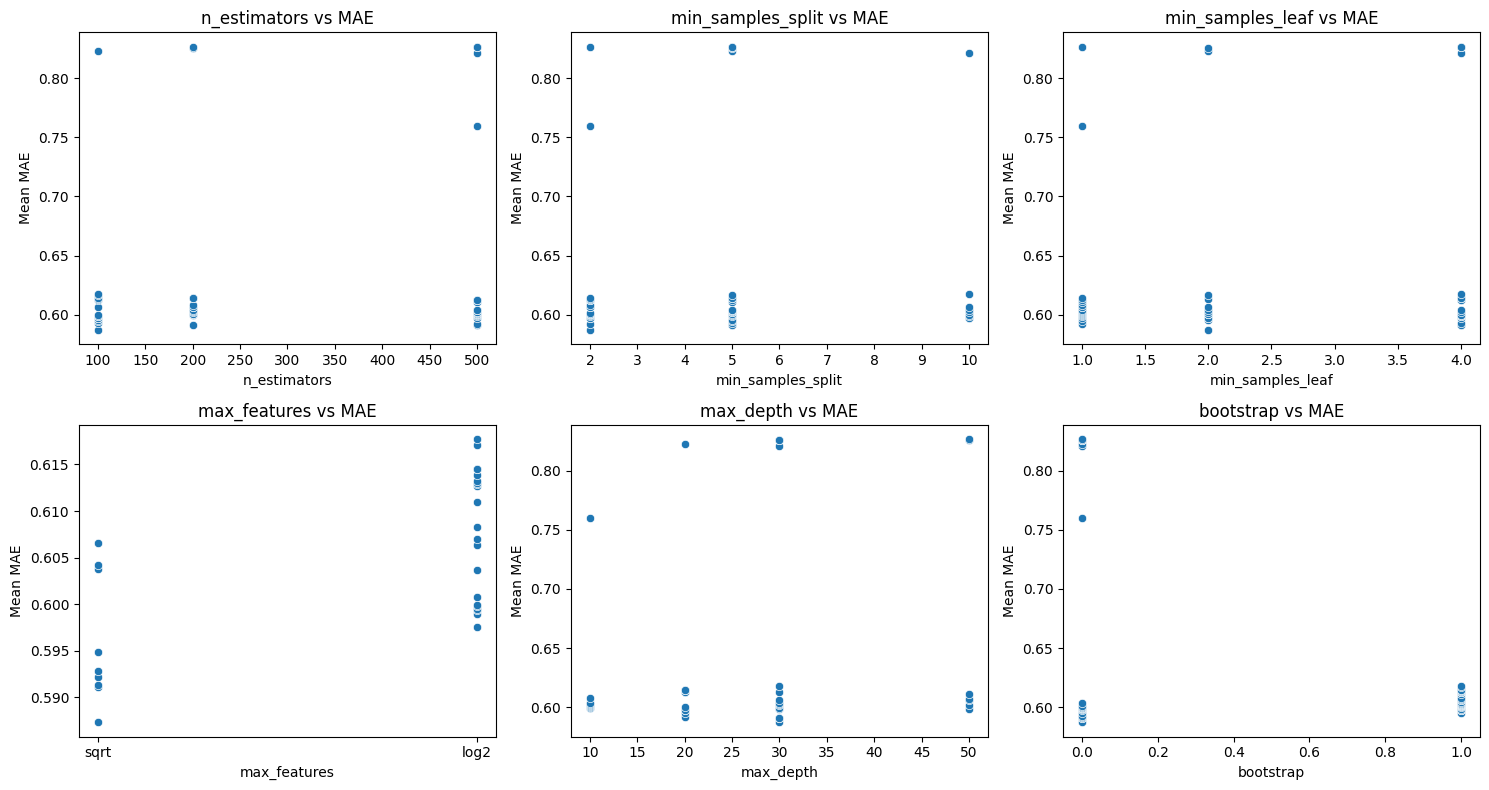

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop columns we don't want to plot (like strings or duplicate metrics)
param_columns = [col for col in results_df.columns if col != "mean_score"]

# Set up a subplot grid
n_cols = 3  # Number of columns in the grid
n_rows = (len(param_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Create one scatterplot per hyperparameter
for i, param in enumerate(param_columns):
    sns.scatterplot(data=results_df, x=param, y='mean_score', ax=axes[i])
    axes[i].set_title(f"{param} vs MAE")
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Mean MAE")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
default_model = RandomForestRegressor()
defaults = default_model.get_params()
defaults['max_features'] = 'None'

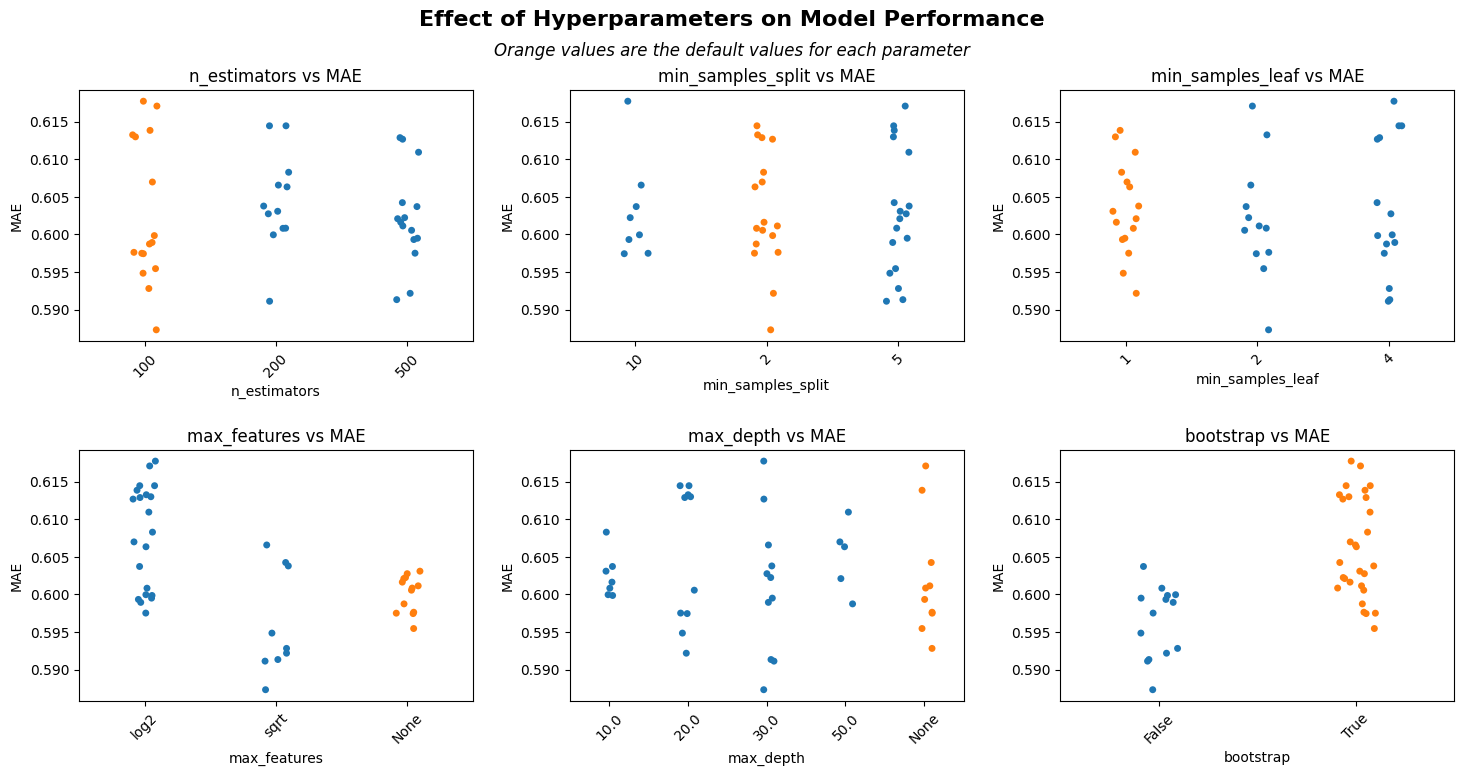

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get default parameters
default_model = RandomForestRegressor()
defaults = default_model.get_params()
defaults['max_features'] = 'None'

# Filter out outliers with high MAEs for clear visualization
filtered_df = results_df[results_df["mean_score"] <= 0.75].copy()

# Drop only the score column; include all params
param_columns = [col for col in results_df.columns if col != "mean_score"]

# Convert all param columns to string for consistent plotting
plot_df = filtered_df.copy()
for col in param_columns:
    plot_df[col] = plot_df[col].astype(str).replace("nan", "None")

# Set up subplot grid
n_cols = 3
n_rows = (len(param_columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot each parameter vs. mean_score
for i, param in enumerate(param_columns):

    default_value = str(defaults[param])
    plot_df['is_default'] = plot_df[param] == default_value

    ordering = sorted(plot_df[param].unique(), key=lambda x: (x == "nan" or x == "None", x)) # put the nan values at the end 
    sns.stripplot(data=plot_df, x=param, y='mean_score', ax=axes[i], order=ordering, jitter=True, hue='is_default', legend=False)
    axes[i].set_title(f"{param} vs MAE")
    # axes[i].set_xlabel(param)
    axes[i].set_ylabel("MAE")
    axes[i].tick_params(axis='x', rotation=45)

fig.suptitle("Effect of Hyperparameters on Model Performance", fontsize=16, fontweight='bold')
fig.text(0.5, 0.94, "Orange values are the default values for each parameter", ha='center', va='top', fontsize=12, style='italic')

plt.tight_layout(pad=2.0)
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
# # Train and evaluate models

# param_dist = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy', 'log_loss']
# }


# models = {
#     "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
# }

# for name, model in models.items():
#     print(f"Starting model {name}")
#     fold_r2_accuracies = [] 
#     fold_mae_accuracies = [] 

#     for fold, (train_index, test_index) in enumerate(kf.split(X)):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
    

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         r2 = r2_score(y_test, y_pred)
#         fold_r2_accuracies.append(r2)

#         mae = mean_absolute_error(y_test, y_pred)
#         fold_mae_accuracies.append(mae)

#         # print(f"Completed fold {fold} with MAE {mae}")

#     mae_scores[name].append(np.average(fold_mae_accuracies))
#     r2_scores[name].append(np.average(fold_r2_accuracies))

#     print(f"Finished property {name} with average MAE {np.average(fold_mae_accuracies)}")

#     # print(f"{name} R² for {target_property}: {r2:.4f}")

## Data Ablation Study

In [2]:
best_hyperparameters = {
    "n_estimators": 100,
    "min_samples_split": 2,
    "min_samples_leaf": 4,
    "max_features": 'log2',
    'max_depth': 10, 
    "criterion": 'absolute_error',
    'bootstrap': False
}

In [3]:
all_r2_accuracies = {}
all_mae = {}

0.9 (604, 768) (604,) -----------
Completed fold 0 with MAE 0.39563070569397973 and R^2 -0.07239883349794196
Completed fold 1 with MAE 0.6351432927325985 and R^2 0.2660901034744775
Completed fold 2 with MAE 0.6591686537189104 and R^2 0.21016085603727253
Completed fold 3 with MAE 0.7832478498779373 and R^2 0.018365067090087117
Completed fold 4 with MAE 0.5645052379760329 and R^2 0.08925796966315247
Completed fold 5 with MAE 0.5507443122247757 and R^2 0.32928089384403003
Completed fold 6 with MAE 0.57765685150177 and R^2 0.2194706468513673
Completed fold 7 with MAE 0.6001864378197593 and R^2 0.207789849003298
Completed fold 8 with MAE 0.7079296819605685 and R^2 0.25138042377598757
Completed fold 9 with MAE 0.6082047014801951 and R^2 0.43766362162131867
0.8 (537, 768) (537,) -----------
Completed fold 0 with MAE 0.39781856729041826 and R^2 -0.0059360330625801705
Completed fold 1 with MAE 0.6494325736671862 and R^2 0.24585290675148086
Completed fold 2 with MAE 0.6452264153118987 and R^2 0.

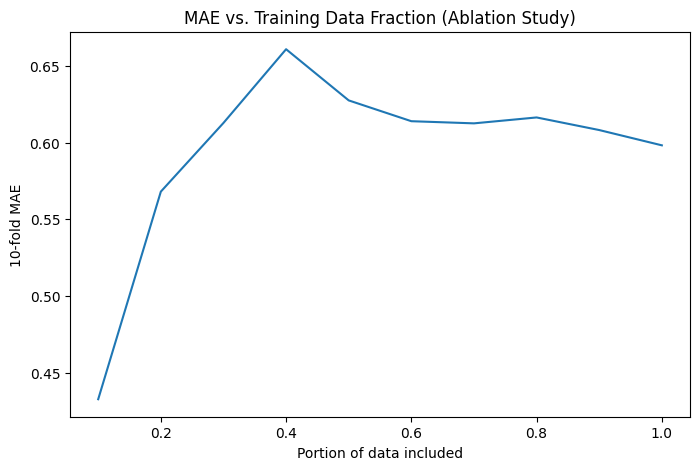

0.9 (604, 768) (604,) -----------
Completed fold 0 with MAE 0.5947682540069896 and R^2 0.14459738683592704
Completed fold 1 with MAE 0.5131953255346745 and R^2 0.3140704677619053
Completed fold 2 with MAE 0.6592858516607137 and R^2 0.05539111950480902
Completed fold 3 with MAE 0.624921181145973 and R^2 0.24145451839131749
Completed fold 4 with MAE 0.5613307220635252 and R^2 0.1623778755313917
Completed fold 5 with MAE 0.647850055714762 and R^2 0.17784102090833653
Completed fold 6 with MAE 0.6083789372215137 and R^2 0.18539934715104245
Completed fold 7 with MAE 0.5239684014849266 and R^2 0.29554475308737493
Completed fold 8 with MAE 0.8103134734087136 and R^2 0.19219301784036047
Completed fold 9 with MAE 0.48791264213680496 and R^2 0.2724604502427904
0.8 (537, 768) (537,) -----------
Completed fold 0 with MAE 0.6068885878884513 and R^2 0.15066019068284442
Completed fold 1 with MAE 0.4224790461879345 and R^2 0.24338888926259183
Completed fold 2 with MAE 0.6570459512075173 and R^2 0.19826

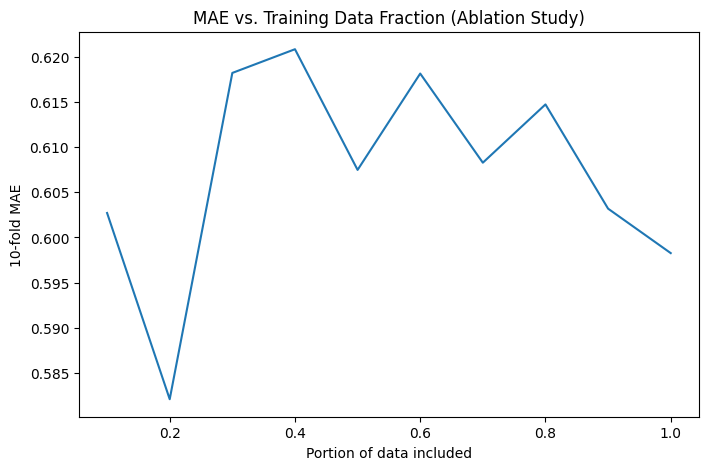

0.9 (604, 768) (604,) -----------
Completed fold 0 with MAE 0.7411512606638329 and R^2 0.2622184105985337
Completed fold 1 with MAE 0.68453070810277 and R^2 0.24257096825294988
Completed fold 2 with MAE 0.5210596082305321 and R^2 0.13005096104030922
Completed fold 3 with MAE 0.5062362192566133 and R^2 0.26248620636083586
Completed fold 4 with MAE 0.6087829243135557 and R^2 0.300386943434919
Completed fold 5 with MAE 0.6656913648632964 and R^2 0.19434821602318375
Completed fold 6 with MAE 0.6204035742667346 and R^2 0.050549813384920594
Completed fold 7 with MAE 0.5780744162372512 and R^2 0.30487498204027363
Completed fold 8 with MAE 0.7017913101455779 and R^2 0.18233324622115843
Completed fold 9 with MAE 0.4865858604124632 and R^2 0.1930380747122259
0.8 (537, 768) (537,) -----------
Completed fold 0 with MAE 0.6591372628470019 and R^2 0.35426098417657825
Completed fold 1 with MAE 0.7356567270082619 and R^2 0.18293218125074384
Completed fold 2 with MAE 0.5735045114336832 and R^2 0.045657

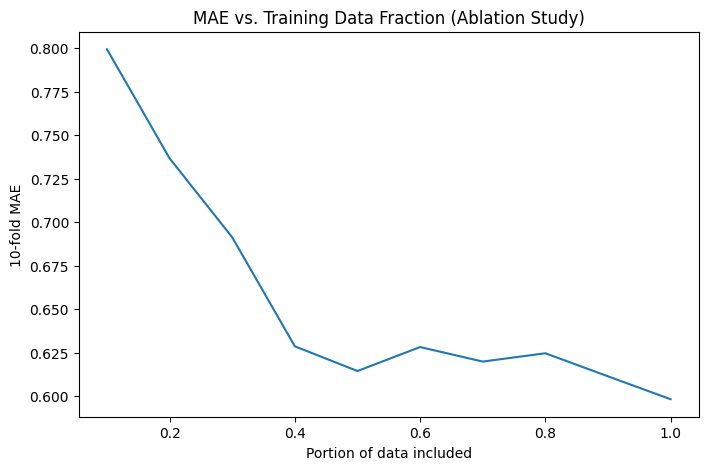

0.9 (604, 768) (604,) -----------
Completed fold 0 with MAE 0.6478525803110808 and R^2 0.24442257681969926
Completed fold 1 with MAE 0.5548018873765486 and R^2 0.23855687392162295
Completed fold 2 with MAE 0.5246509809591325 and R^2 0.4450612586159708
Completed fold 3 with MAE 0.7052001153772903 and R^2 0.1812129955102808
Completed fold 4 with MAE 0.5987341093039574 and R^2 0.4545221594179458
Completed fold 5 with MAE 0.7117432635887507 and R^2 0.16606657946777714
Completed fold 6 with MAE 0.5638444404380841 and R^2 0.058741726089653334
Completed fold 7 with MAE 0.6669569506214101 and R^2 0.1210783047474906
Completed fold 8 with MAE 0.555147617919184 and R^2 0.168721737205348
Completed fold 9 with MAE 0.48842909761236636 and R^2 0.25625374348235874
0.8 (537, 768) (537,) -----------
Completed fold 0 with MAE 0.5844713886621552 and R^2 0.284700548764689
Completed fold 1 with MAE 0.5348775271886734 and R^2 0.2517326914251291
Completed fold 2 with MAE 0.6448327875048674 and R^2 0.340994446

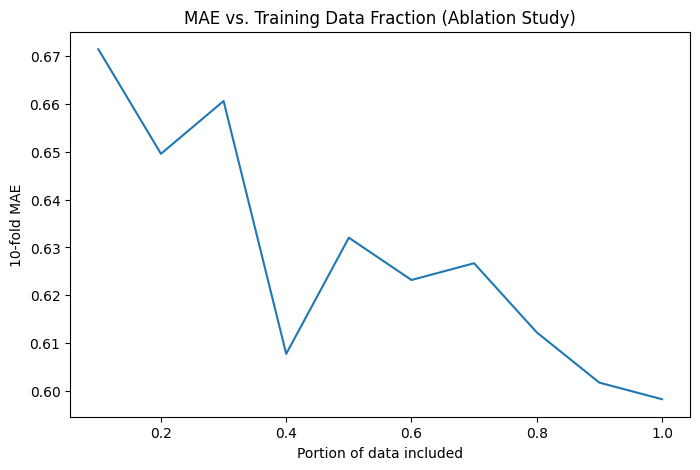

0.9 (604, 768) (604,) -----------
Completed fold 0 with MAE 0.5102261857365825 and R^2 0.23825911394338872
Completed fold 1 with MAE 0.6073766297655695 and R^2 0.22085115312753467
Completed fold 2 with MAE 0.7026544297884153 and R^2 0.14240387327310644
Completed fold 3 with MAE 0.5721812556275141 and R^2 0.04797821786756307
Completed fold 4 with MAE 0.6888639763366846 and R^2 0.24990628983847663
Completed fold 5 with MAE 0.5843367615356064 and R^2 0.3544795846513179
Completed fold 6 with MAE 0.5792980000252859 and R^2 0.26094360105718795
Completed fold 7 with MAE 0.6226657636637263 and R^2 -0.0152314994783318
Completed fold 8 with MAE 0.5600952538372997 and R^2 0.2464822452057972
Completed fold 9 with MAE 0.5766410761558317 and R^2 0.2644910670805971
0.8 (537, 768) (537,) -----------
Completed fold 0 with MAE 0.5215579888417401 and R^2 0.2173714034687677
Completed fold 1 with MAE 0.5966230814257079 and R^2 0.13356129789958437
Completed fold 2 with MAE 0.7199264543501668 and R^2 0.18248

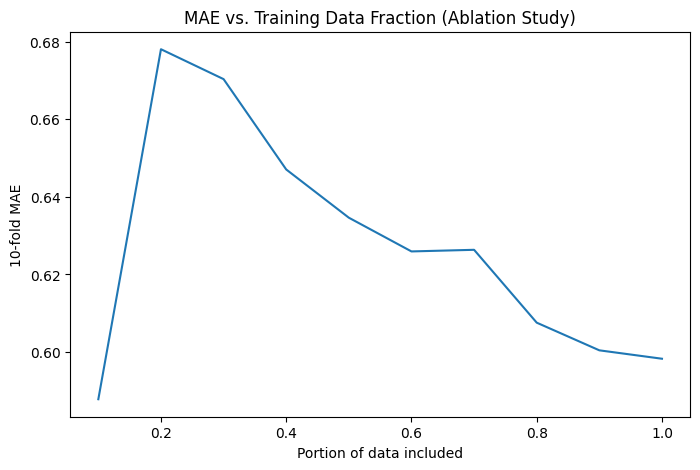

0.9 (604, 768) (604,) -----------
Completed fold 0 with MAE 0.6449166786978275 and R^2 0.24409590319656171
Completed fold 1 with MAE 0.6774735509843289 and R^2 0.23823462094549797
Completed fold 2 with MAE 0.6531986828105854 and R^2 0.3174254977417966
Completed fold 3 with MAE 0.5592556380324253 and R^2 0.19209893188270677
Completed fold 4 with MAE 0.5064924110895712 and R^2 0.23371436873643125
Completed fold 5 with MAE 0.6638074605110896 and R^2 0.06856567244084599
Completed fold 6 with MAE 0.5708647049857224 and R^2 0.20371552621864453
Completed fold 7 with MAE 0.5141567577364629 and R^2 -0.03574749380946707
Completed fold 8 with MAE 0.6576595915772404 and R^2 0.24893719106604606
Completed fold 9 with MAE 0.6318639566118909 and R^2 0.17762447840642182
0.8 (537, 768) (537,) -----------
Completed fold 0 with MAE 0.6809603021271537 and R^2 0.2487751934009611
Completed fold 1 with MAE 0.6927147368161035 and R^2 0.2085564652287114
Completed fold 2 with MAE 0.66191844427402 and R^2 0.29053

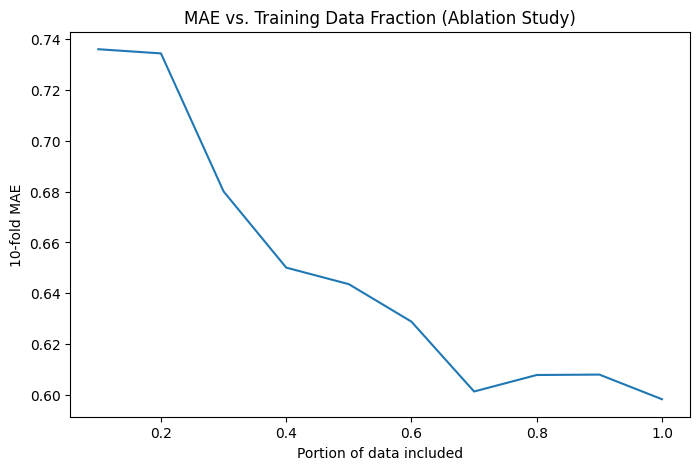

0.9 (604, 768) (604,) -----------
Completed fold 0 with MAE 0.5418549579728981 and R^2 0.17646721461386328
Completed fold 1 with MAE 0.5269144164389882 and R^2 0.3193021393416884
Completed fold 2 with MAE 0.698913329664057 and R^2 0.21616672292380923
Completed fold 3 with MAE 0.6276486493227499 and R^2 0.2168632076686039
Completed fold 4 with MAE 0.5933230662466326 and R^2 0.3506125334429935
Completed fold 5 with MAE 0.6959334418011304 and R^2 0.16453110809979432
Completed fold 6 with MAE 0.564899381406367 and R^2 0.2334565061609586
Completed fold 7 with MAE 0.6732976224715458 and R^2 0.044912407457344705
Completed fold 8 with MAE 0.5536418559551871 and R^2 0.3228843308086794
Completed fold 9 with MAE 0.49794826901812683 and R^2 0.282021369289461
0.8 (537, 768) (537,) -----------
Completed fold 0 with MAE 0.5648795173561619 and R^2 0.1595686019497392
Completed fold 1 with MAE 0.5542095550399058 and R^2 0.31422127550139567
Completed fold 2 with MAE 0.6040405029216326 and R^2 0.309560463

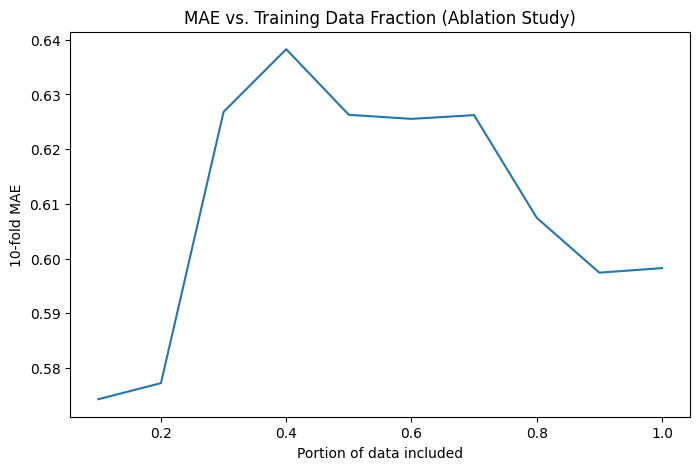

0.9 (604, 768) (604,) -----------
Completed fold 0 with MAE 0.6114793671653672 and R^2 0.2668279357480329
Completed fold 1 with MAE 0.4905203105229648 and R^2 0.06587108754522986
Completed fold 2 with MAE 0.5493693069093865 and R^2 0.14008116953749816
Completed fold 3 with MAE 0.7972397045483955 and R^2 0.08288496267905276
Completed fold 4 with MAE 0.630583412197321 and R^2 0.16118821532292604
Completed fold 5 with MAE 0.6095654335491012 and R^2 0.29634755922463263
Completed fold 6 with MAE 0.5785762981738942 and R^2 0.3326436542375152
Completed fold 7 with MAE 0.5864545705329818 and R^2 -0.05280675083209796
Completed fold 8 with MAE 0.4383960945235867 and R^2 0.31227071713910426
Completed fold 9 with MAE 0.572142227039844 and R^2 0.32763458354834174
0.8 (537, 768) (537,) -----------
Completed fold 0 with MAE 0.670067404268639 and R^2 0.21860296332255402
Completed fold 1 with MAE 0.4556275259746397 and R^2 0.14109290767567662
Completed fold 2 with MAE 0.528756995369197 and R^2 0.050020

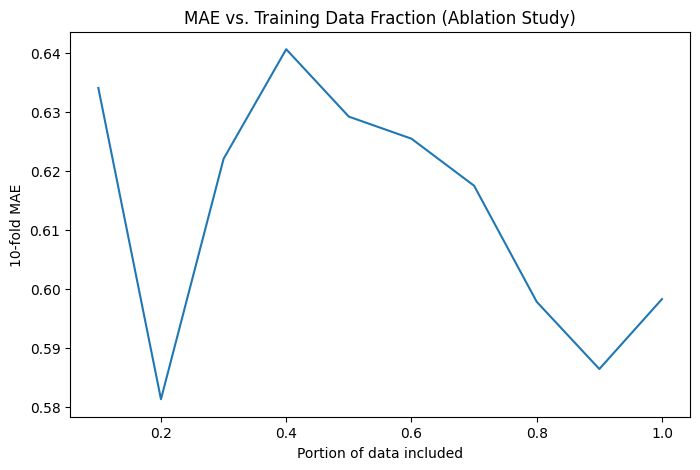

0.9 (604, 768) (604,) -----------
Completed fold 0 with MAE 0.5986669778584573 and R^2 0.1450497940727008
Completed fold 1 with MAE 0.653950586200959 and R^2 0.09633142419455165
Completed fold 2 with MAE 0.5852107459942467 and R^2 0.16820703519346714
Completed fold 3 with MAE 0.5105370265129763 and R^2 0.3312726216332098
Completed fold 4 with MAE 0.6592797043985565 and R^2 0.23492257913029835
Completed fold 5 with MAE 0.5654078708092025 and R^2 0.464326930191003
Completed fold 6 with MAE 0.6011283614987267 and R^2 0.2959678344049024
Completed fold 7 with MAE 0.6650442450690824 and R^2 0.2988676949703908
Completed fold 8 with MAE 0.4794921507912592 and R^2 0.3260024076194151
Completed fold 9 with MAE 0.674667699277639 and R^2 0.0986905565921431
0.8 (537, 768) (537,) -----------
Completed fold 0 with MAE 0.624645877003403 and R^2 0.1500499662256819
Completed fold 1 with MAE 0.5918257482027486 and R^2 0.11275283471631148
Completed fold 2 with MAE 0.5940274966618758 and R^2 0.2197887400093

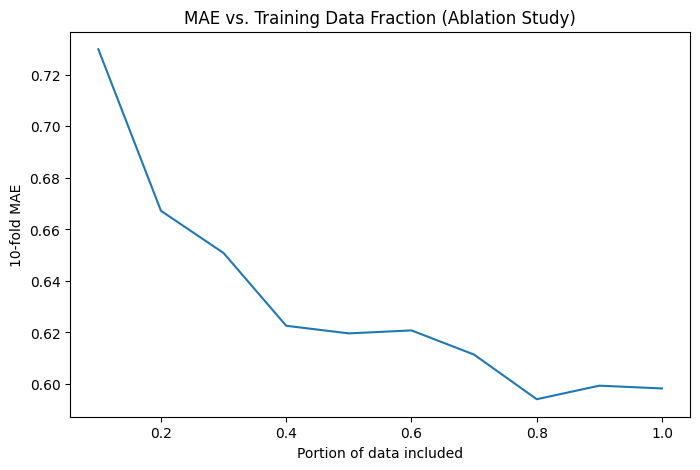

In [17]:

# Train and evaluate models
model = RandomForestRegressor(**best_hyperparameters, random_state=42)

# fig, axes = plt.subplots(2, 5, figsize=(20, 10))
# plt.title("Text-only Optimized Model Prediction Performance")

fold_r2_accuracies = {}
fold_mae_accuracies = {} 
kf = KFold(n_splits=10, shuffle=False)

# for seed in [42, 0, 2, 5, 10, 15]:
# for seed in [1, 3, 4]:
for seed in range(1, 10):
    np.random.seed(seed)
    indices = np.random.permutation(len(X))

    portions = [round(1 - 0.1 * i, 1) for i in range(10)]
    fold_r2_accuracies[1] = all_r2_accuracies[0][1]
    fold_mae_accuracies[1] = all_mae[0][1]

    for portion in portions[1:]:
        index_mask = indices[:int(len(indices) * portion)]

        X_portioned = X[index_mask]
        y_portioned = y[index_mask]
        print(portion, X_portioned.shape, y_portioned.shape, "-----------")

        fold_r2_accuracies[portion] = []
        fold_mae_accuracies[portion] = []

        for fold, (train_index, test_index) in enumerate(kf.split(X_portioned)):
            X_train, X_test = X_portioned[train_index], X_portioned[test_index]
            y_train, y_test = y_portioned[train_index], y_portioned[test_index]


            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            fold_r2_accuracies[portion].append(r2)

            mae = mean_absolute_error(y_test, y_pred)
            fold_mae_accuracies[portion].append(mae)

            print(f"Completed fold {fold} with MAE {mae} and R^2 {r2}")


    all_r2_accuracies[seed] = fold_r2_accuracies
    all_mae[seed] = fold_mae_accuracies

    average_MAEs = [np.mean(all_mae[seed][portion]) for portion in portions]

    plt.figure(figsize=(8, 5))
    plt.plot(portions, average_MAEs)

    plt.xlabel("Portion of data included")
    plt.ylabel("10-fold MAE")
    plt.title("MAE vs. Training Data Fraction (Ablation Study)")
    plt.show()

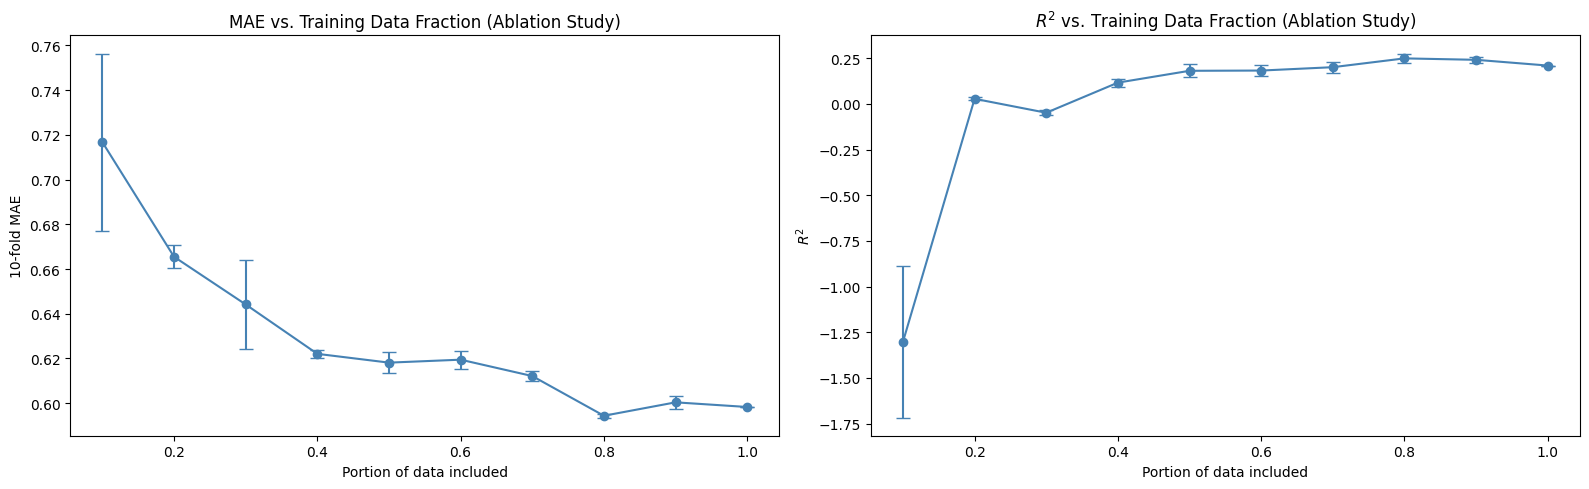

In [18]:
import matplotlib.pyplot as plt

r2_all_data = np.array([
    [np.mean(all_r2_accuracies[seed][portion]) for portion in portions] for seed in all_mae.keys()
])

all_mae_data = np.array([
    [np.mean(all_mae[seed][portion]) for portion in portions] for seed in all_mae.keys()
])

# Create a figure with 1 row and 2 columns for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: MAE vs. Training Data Fraction
axs[0].errorbar(portions, all_mae_data.mean(axis=0), yerr=all_mae_data.std(axis=0), fmt='-o', capsize=5, color='steelblue')
axs[0].set_xlabel("Portion of data included")
axs[0].set_ylabel("10-fold MAE")
axs[0].set_title("MAE vs. Training Data Fraction (Ablation Study)")

# Plot 2: R^2 vs. Training Data Fraction
axs[1].errorbar(portions, r2_all_data.mean(axis=0), yerr=r2_all_data.std(axis=0), fmt='-o', capsize=5, color='steelblue')
axs[1].set_xlabel("Portion of data included")
axs[1].set_ylabel(r'$R^2$')
axs[1].set_title(r'$R^2$ vs. Training Data Fraction (Ablation Study)')

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()